# Using Markov Chain Transition Probabilities as Features for Machine Learning

This notebook demonstrates the estimation of Markov chain transition probabilities and using the estimated values as a feature vector for further processing and machine learning tasks. 


### Table of Contents
* [Simulating Markov Chain](#simulate-markov-chain)
    * [Generating Samples from a Model](#generate-sequence-from-p)
    * [Visualize Sequence](#visualize-sequence)
    * [Visualizing Multiple Sequences and Inspecting Similarities](#visualize-multiple-sequences)
    * [Visualizing Similarities Between Pairs of Time Series](#visualize-similarities)
* [Estimating the Stochastic Matrix and Feature Vector for Time Series](#estimating-matrix)
    * [Estimating the Stochastic Matrix From Observations](#estimation-from-observation)
    * [Estimation Accuracy](#estimation-accuracy)
    * [Calculating Features for Time Series](#calculating-features)
    * [Calculating the Principal Components for Visualizing the Clusters](#pca-and-visualization)
    
### Introduction

As majority of the machine learning algorithms require the input data in a tabular, fixed length normalized vector format, performing ML tasks on arbitrary length time series data is often not straightforward. This kernel demonstrates the use of Markov chain modelling to convert an arbitrary-length observed sequence into a fixed length feature vector by capturing the most of the information available in the observed sequence. Once the feature vector is computed, it can be used in many different data science tasks and classical, highly explainable ML algorithms for tasks such as, visualization, clustering, classification etc.


According to Wikipedia definition;
> A Markov chain is a stochastic model describing a sequence of possible events in which the probability of each event depends only on the state attained in the previous event. 

A Markov chain is useful for modelling sequences of observations/measurements/events or any other stochastic process with Markov assumption, meaning that, the probability distribution of the next value in the sequence, only depends on the previous value and does not depend on the past history, as can be seen in below equation:

$$P(X_n=x_n|X_{n-1} = x_{n-1}, X_{n-2}=x_{n-2}{\dotsb}X_0=x_0)=P(X_n=x_n|X_{n-1}=x_{n-1})$$


Markov chains can be used for modelling a broad range of phenomena such as;

 - Evolution of state of a system  
 - Successive actions taken by a user
 - Gene and protein sequences
 

A discrete time, finite state Markov chain can be modeled by its ___Stochastic matrix___, that is a square matrix used to describe the 'transition probabilities' of the chain between pairs of states. Assuming that our random process can be in either one of two states, 
$$a_1,a_2$$

and has the stochastic matrix shown below:

$$P=
\begin{pmatrix}
a_{11} & a_{12} \\
a_{21} & a_{22}
\end{pmatrix}
$$

This matrix can be interpreted as;
- When the system is in state $a_1$, the next state of the system will be $a_1$ with probability $a_{11}$
- When the system is in state $a_1$, the next state of the system will be $a_2$ with probability $a_{12}$
- When the system is in state $a_2$, the next state of the system will be $a_1$ with probability $a_{21}$
- When the system is in state $a_2$, the next state of the system will be $a_2$ with probability $a_{22}$


$$P=
\begin{pmatrix}
0.1 & 0.9 \\
0.7 & 0.5
\end{pmatrix}
$$


Now that we have the basics, let's get to the code!


<a id='simulate-markov-chain'></a>
# Simulating Markov Chains

In [1]:
#Importing required libraries

import numpy as np
import pandas as pd
from random import seed
from random import random
import matplotlib.pyplot as plt
import seaborn as sns
import inspect
from bokeh.io import curdoc, show
from bokeh.models import ColumnDataSource, Grid, LabelSet, LinearAxis, Plot, Wedge, CategoricalColorMapper
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
from bokeh.layouts import row
from matplotlib.colors import rgb2hex as rgb2hex
import matplotlib.cm as cm

output_notebook()

Loading BokehJS ...

In [2]:
#Some helpers for inspecting variables
def print_var(x):    
    print(retrieve_name(x) + ': ' + str(x))

def retrieve_name(var):
    for fi in reversed(inspect.stack()):
        names = [var_name for var_name, var_val in fi.frame.f_locals.items() if var_val is var]
        if len(names) > 0:
            return names[0]    

Assuming that our Markov chain has state space:
$$(1,2,3)$$

The chain can be in one of these states at any given time, and the stochastic matrix needs to be in the form $3x3$ such as;

$$P=
\begin{pmatrix}
p_{11} & p_{12} & p_{13} \\
p_{21} & p_{22} & p_{23} \\
p_{31} & p_{32} & p_{33}
\end{pmatrix}
$$

In order to be used as a stochastic matrix, each row of the matrix need to sum up to 1: 

$$p_{11}+p_{12}+p_{13}=1$$ 

This implies that the total probability of transitioning to any one of the states (including itself), from a state should be ___1___ (certain event). In the cell below, we are defining a function for generating random NxN matrices to be used as state transition probabilities for Markov chains.



In [3]:
def generate_P(N = 3):
    '''
    Generates a stochastic matrix with the specified size
    '''
    P = np.random.rand(N, N)   
    #Divide each row by sum of the entire row to normalize row to 1
    P = P/P.sum(axis=1)[:,None]
    return P

def noisify(base_p, noise_factor = 0.05):
    '''
    Adds random noise to given matrix
    '''
    (M,N) = base_p.shape
    P = np.random.rand(N, N)   
    #Divide each row by sum of the entire row to normalize row to 1
    sampled = base_p + P * noise_factor
    sampled = sampled/sampled.sum(axis=1)[:,None]
    return sampled

In [4]:
#Let's take a peek at an example stochastic matrix
P = generate_P()
noisy = noisify(P)
print(P)
print(noisy)
print(noisy.sum(axis=1))#Make sure every row sums up to 1

[[0.06966012 0.32439543 0.60594445]
 [0.30753984 0.43372741 0.25873274]
 [0.39178367 0.51271749 0.09549885]]
[[0.10880366 0.31918303 0.57201331]
 [0.31169766 0.42471918 0.26358316]
 [0.38444447 0.51222514 0.10333038]]
[1. 1. 1.]


<a id='generate-sequence-from-p'></a>
### Generating Samples from a Model

In the next cell, we will define a function to iterate a markov chain, that takes current state of the chain and the stochastic matrix as inputs, and generates the next sample accordingly.

Given the current state, we first slice the stochastic matrix to obtain the row with state transition probabilities that are originating from the current state. 

As an example, if the current state is ___'2'___, the associated row of the stochastic matrix would be:

$$
\begin{pmatrix}
p_{21} & p_{22} & p_{23}
\end{pmatrix}
$$

To obtain the next state of the chain, we can use these values as probability mass function of a multinomial distribution and sample from that distribution. 

The function below is heavily commented, so please check in case you are looking to understand the steps. Please note that below implementation is probably less efficient than a library implementation of multinomial random number generation such as numpy, however is beneficial for understand the inner workings of the algorithm.

In [5]:
def iterate_process(current_state, P):
    x,y = P.shape
    if(x != y):
        raise ValueError('State transition matrix needs to be a square matrix')
        
    if(current_state >= x):
        raise ValueError(f"Current state should be a in {range(x)}")
    
    if(current_state < 0):
        raise ValueError('Current state should be a positive integer')
    
    #Get the row with index of the current state, mask other rows out
    #That row is the multinomial  probability mass function, that lists the 
    #discrete probability values for transitioning to target states from the current state
    
    pmf = np.ma.masked_values((P[current_state]), 0.0) 
    
    
    cdf = np.cumsum(pmf) #Compute cdf from pmf
    cdf = np.insert(cdf, 0, 0) #Insert 0 to the 0th position
        
    r = np.random.uniform(0.0, 1.0) #Sample from uniform [0,1]
    m = (np.where(cdf < r))[0] #Get indices of elements with value less than 'r'
    next_state=m[len(m)-1] #Next state is the 
    return next_state

Now that we have defined methods for generating the stochastic matrix and iterating the Markov chain, we can go ahead and put these together to generate a sequence of samples.
Below function generates a realization of the random process with specified length

In [6]:
def generate_sequence(P, l=1000):
    state = 0
    sequence = []
    
    for i in range(l):
        #Appending each new sample to the array to obtain a time-series
        sequence.append(state)
        state = iterate_process(state, P)
        
    return sequence

<a id='visualize-sequence'></a>
### Visualizing Sequences and Stochastic Matrices

As the next step, we can visualize the results to gain some insigth into the random process we have synthesized. 

For concreteness of the example let's assume that these sequences are generated by a real case as described below:

Assume that there's an IoT device installed on a road with 2 lanes, that observes how many vehicles are passing in front of it and reports this information to a cloud service, at regular time intervals. Since the road has 2 lanes, the number of vehicles that can appear in device's observation area can be either 0, 1 or 2 at most. 

After collecting these measurements, the resulting data would look something like below:

$$[0,1,0,1,2,1,1,0,0,{\dotsb}2,1,1,2,1,2,2,1,2]$$

Several remarks can be made by inspecting the sequence.


In [7]:
#Define some functions to be used for visualizing a single sequence along with it's stochastic matrix

def get_sample_figure(samples, h, w):
    '''
    Generates a heatmap-like figure for visualizing sequences
    '''
    plot_samples = figure(
    title="# of Vehicles vs Time",
    x_axis_label="Sample Index",
    width=w,
    height=h)    
    
    palette=['#1f59b9','#f9b749','#9528c7']
    colors = [palette[i] for i in samples]
    index = range(len(samples))
    plot_samples.rect(index, y=0.3, width=1,
       height=1, color=colors)
    plot_samples.yaxis.visible=False
    
    return plot_samples

def get_matrix_figure(P, h, title = 'Stochastic Matrix'):
    '''
    Plots a matrix as a heatmap
    '''
    map_range = ['s0', 's1', 's2']
    
    plot_matrix= figure(
        title=title, width=h,
        height=h, toolbar_location=None,
        x_range=map_range, y_range=map_range
    )
    x = [0.5,1.5,2.5,0.5,1.5,2.5,0.5,1.5,2.5]
    y = [0.5,0.5,0.5,1.5,1.5,1.5,2.5,2.5,2.5]
    
    cmap=cm.jet
    matrix_colors = [rgb2hex(cmap(c)) for c in P.flatten()]
    plot_matrix.rect(x, y, color=matrix_colors, width=1, height=1)


    x_annot = [0,0,0,1,1,1,2,2,2]
    y_annot = [0,1,2,0,1,2,0,1,2]
    
    label_source = ColumnDataSource(data=dict(x=x, y=y, vals= np.round(P.flatten(),3)))   
    labels = LabelSet(x='x', y='y', text='vals',
                      x_offset=-12, y_offset=-5, source=label_source,
                      render_mode='css',text_font_size='1em', text_color='white')


    plot_matrix.add_layout(labels)
    #plot_matrix.add_tools(HoverTool(tooltips=None))
    return plot_matrix

def plot_sequence(P, samples, h=175, w=1000):
    
    plot_samples = get_sample_figure(samples, h, w)
    plot_matrix = get_matrix_figure(P, h)

    show(row(plot_matrix, plot_samples))
    

In [8]:
#Generate a sequence to simulate # of cars passing through a road with 3 lanes at any successive measurements

N = 3 # |StateSpace|
L=250 #Length of sequence (# of measurements)

np.random.seed(2) # random seed for reproducability
P = generate_P(N) #distribution for markov chain

traffic = generate_sequence(P,L)

plot_sequence(P, traffic)

<a id='visualize-multiple-sequences'></a>
### Generate and Visualize Multiple Sequences

In the cell below, we generate 3 different stochastic matrices, each one representing a different __regime__ of traffic. 

The 1st stochastic matrix corresponds to a _quite_ traffic regime. The state is 0 most of the time, in other words, most of the measurements yield 0 cars passing through the road, with occasional 1 or 2 cars.

$$P_{quite}=
\begin{pmatrix}
0.85 & 0.10 & 0.05 \\
0.95 & 0.04 & 0.01 \\
0.95 & 0.03 & 0.02
\end{pmatrix}
$$

The 2nd stochastic matrix corresponds to a usual traffic regime, with the most likely measurement being 1. As can be seen in below matrix, the transition probabilities targeting state 1 is highest in all rows. (Regardless of the current state, the most likely next step is 1)

$$P_{usual}=
\begin{pmatrix}
0.20 & 0.60 & 0.20 \\
0.10 & 0.70 & 0.30 \\
0.15 & 0.55 & 0.30
\end{pmatrix}
$$

Finally, the 3rd stochastic matrix represents a _busy_ traffic regime, with the state '2 cars' being the most likely.

$$P_{busy}=
\begin{pmatrix}
0.05 & 0.25 & 0.70 \\
0.05 & 0.35 & 0.60 \\
0.01 & 0.09 & 0.90
\end{pmatrix}
$$


In the cell below, we take these 3 matrices as bases for different regimes of traffic and, generate 30 different observation sequences. We can consider these sequences as measurements taken during different 5 minute intervals of the same day. In each one of the measurement intervals, the traffic is in either one of 3 defined regimes, i.e the stochastic matrix is ___close to___ either one of the matrices. We have generated the stochastic matrices for these 30 observation sequences adding random noise to the base regime matrices.

The notion of ___closeness___ is particularly important in this exercise since the objective is to __estimate the stochastic matrix of given sequences and using this matrix as a feature vector for clustering algorithms__, in which the concept of distance and closeness is central.



<AxesSubplot:>

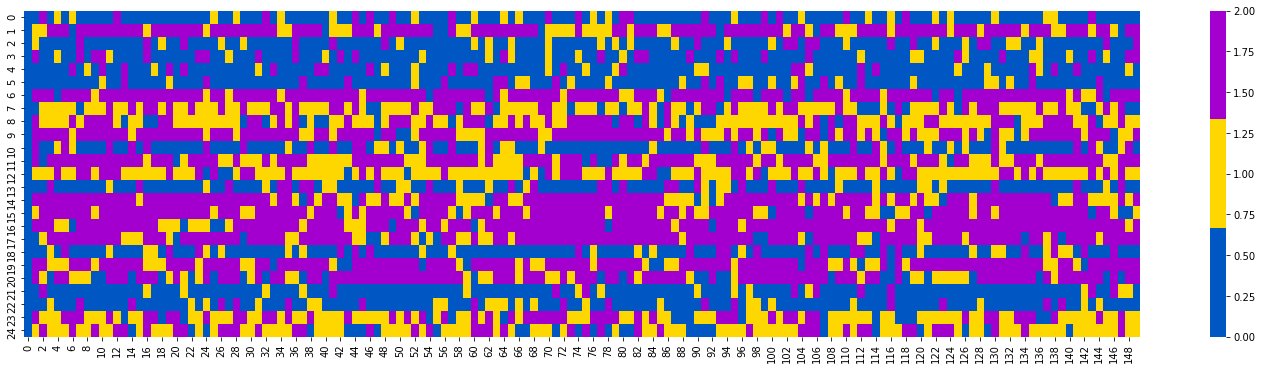

In [9]:
N = 3 # |StateSpace| 
observations = []
sequence = []
P_s = []
traffic_states = []


p_quiet = [ #Calm-traffic
    0.85, 0.1, 0.05,
    0.95, 0.04, 0.01,
    0.95, 0.03, 0.02]

p_usual = [ # casually-active
    0.2, 0.6, 0.2,
    0.1, 0.7, 0.3,
    0.15, 0.55, 0.3]

p_busy =[ # extremely busy/congestion
    0.05, 0.25, 0.7,
    0.05, 0.35, 0.6,
    0.01, 0.09, 0.9]

regimes = [
    np.array(p_quiet).reshape(3,3),
    np.array(p_usual).reshape(3,3),
    np.array(p_busy).reshape(3,3)
]

for i in range(100):
    regime = np.random.choice([0, 1, 2])  #pick a random regime
    P = noisify(regimes[regime], noise_factor=0.2)
    P_s.append(P)
    traffic_states.append(regime)
    sequence = generate_sequence(P, l=1000) 
    observations.append(sequence)
    
    
plt.figure(figsize=(25, 6))
cmap = sns.color_palette("prism", N)

#visualize first 150 samples of each sequence
sns.heatmap(np.asarray(observations)[:25,:150], cmap=cmap, annot=False)

Each row of the above heatmap visualizes one of the realizations of the random process (sequence of observations). The regime of traffic has been randomly selected for each sequence, and resembles either one of the traffic states defined (quiet, usual, busy).

As can be seen in the heatmap, some of the rows are mostly yellow, where others are either mostly blue or, mostly purple. Althgough the sequences are generated completely randomly and none of the rows are identical, sequences generated by a particular regime generate similar visualizations. 

In the visualization above, rows can be interpreted by their dominant color such as;

>  * Mostly blue (0) if traffic is in __quite__ regime
>  * Mostly yellow (1) if traffic is in __usual__ regime
>  * Mostly purple (2) if traffic is in __busy__ regime


As you can see in the next cell, sequences generated by similar stochastic matrices look similar. This result confirms that the similarity between these random time series is also reflected in their corresponding stochastic matrices, and the stochastic matrix can capture some aspect of the similarities of observed time series. 

In following parts of this kernel, we are going to work the other way around and try to identify the traffic regimes underlying the observed time series by their estimated stochastic matrices.

In [10]:
#Select 2 sequences from each regime and visualize
traffic_states = np.array(traffic_states)
quiet_observations = np.where(traffic_states == 0)[0][:2] #time series with quite traffic profile
usual_observations = np.where(traffic_states == 1)[0][:2] #usual traffic
busy_observations = np.where(traffic_states == 2)[0][:2]  #busy traffic

<a id='visualize-similarities'></a>
### Visualize Pairs of Observations and Investigate Similarities

#### Two sequences generated by a quiet traffic profile
As can be seen in below visualizations, similar stochastic matrices generate similar sequences.

In [11]:
index0 = quiet_observations[0]
index1 = quiet_observations[1]
#plot_sequence(P,samples)
plot_sequence(P_s[index0], observations[index0][:150])
plot_sequence(P_s[index1], observations[index1][:150])

#### Two sequences generated by a usual traffic profile

In [12]:
index0 = usual_observations[0]
index1 = usual_observations[1]

plot_sequence(P_s[index0], observations[index0][:150])
plot_sequence(P_s[index1], observations[index1][:150])

#### Two sequences generated by a busy traffic profile

In [13]:
index0 = busy_observations[0]
index1 = busy_observations[1]

plot_sequence(P_s[index0], observations[index0][:150])
plot_sequence(P_s[index1], observations[index1][:150])

<a id='estimating-matrix'></a>
# Estimating the Stochastic Matrix and Feature Vector for Time Series

Let's get back to the original objective of this exercise which is,  ___given a sequence of observations, estimating the stochastic matrix and using this matrix as a feature vector.___ This feature vector can later be used by different machine learning algorithms for various tasks such as understanding the natural groupings and different traffic regimes (dimensionality reduction, visualization, clustering) or predicting the traffic density based on observations of the road.

Generally, machine learning algorithms require tabular data with a fixed format, unlike unbounded time series data, therefore, fitting a Markov chain as a preprocessing step in an ML pipeline can be useful for converting arbitrary length time series observations into a fixed length vectore, that summarizes the dynamic behavior of the underlying process.

Using Markov chains become tricky, due to the strong assumption of _Markov property_, and the underlying process that have generated the data may not necessarily be a good fit, which will result in a model that is not perfect, and may only be applicable under certain conditions, however, as long as the model serves the objectives of the task, we can use it by acknowledging its limitations and being prepared to mitigate the drawbacks. As stated above, as long as the Markov chain model can capture interesting aspects of the dynamic behavior of the observed time series, we can use it for creating a feature vector out of observations.

In the cell below, we are defining a function which takes a random sequence as an argument and returns the estimated stochastic matrix. The process of estimating the state transition probabilities of a Markov chain is as simple as counting the observed state transitions and calculating state transition frequencies.

Below function implementation is perhaps highly inefficient, however simple and commented enough to understand the estimation process.

In [14]:
def estimate_p(sequence, L=0):
    '''
    Function for estimating the stochastic matrix of a given Markov chain realization (observations)
    Optional parameter L can be used for specifying the number of observations to use in estimation
    '''
    #make sure the length to be used in estimation does not exceed the available length
    #use entire data available if L is not specified
    Ls = len(sequence)    
    if L==0 or L > Ls:
        L = Ls
    
    #get the number of distinct states in the sequence (State Space)
    N = np.unique(seq).shape[0]
    
    p_hat = np.zeros((N,N))
    
    #loop through the sequence and count the state transitions
    previous_state = sequence[0]
    for state in sequence[1:L]:
        current_state = state
        p_hat[previous_state, current_state] +=1
        previous_state = current_state
    
    p_hat = p_hat/L
    p_hat = p_hat/p_hat.sum(axis=1)[:,None]
    
    return p_hat

<a id='estimation-from-observation'></a>
### Estimating the Stochastic Matrix From Observations

In [15]:
#Let's try the estimation function

p = noisify(regimes[0], noise_factor=0.2)
seq = generate_sequence(p, l=5000)

#Let's try the estimation function 

p_hat = estimate_p(seq)

p_figure = get_matrix_figure(p, h=175, title='Original')
p_hat_figure = get_matrix_figure(p_hat, h=175, title='Estimated')
show(row(p_figure, p_hat_figure))

<a id='estimation-accuracy'></a>
    
### Estimation Accuracy
    
Although studying the estimation accuracy is not the goal of this notebook, we can play with the parameter `L` and investigate how it affects the estimation error, which can help us tune the _number of observations_ used for estimating the Markov chain. To find a good balance between  accuracy and performance, we will run the estimation using some values of hyperparameter L.  

In [16]:
#different values for the parameter to try
lengths = [50, 100, 200, 500, 1000, 2000, 3000, 5000]

p_hats = []
errors = []

for L in lengths:
    p_hat = estimate_p(seq, L)
    p_hats.append(p_hat)
    
    #error matrix
    p_diff = p - p_hat
    
    #Sqrt of sum of all components of the error matrix
    error = np.sqrt(np.sum(p_diff**2))
    errors.append(error)


fig = figure(title="Estimation Error", x_axis_label='# of Observations Used (L)', y_axis_label='Sum of Squared Error')
fig.line(x=lengths, y=errors)
show(fig)

As can be seen in the figure above, the estimation error decreases as more observations are taken into account for estimation. In the next cell, we will estimate the stochastic matrices for previously generated 100 observations. For a reasonable balance between estimation accuracy and duration, we will move forward with 1000 samples for estimation.


<a id='calculating-features'></a>
### Calculating Features for Time Series

In the cell below, we will estimate the stochastic matrices for previously generated 100 observations. Since our goal is to use this matrix as a feature vector, we will then flatten the matrix and inspect the values. ___The result of the following cell is a dataset of i.i.d observations with 9 dimentions.___ 

For better visualization and investigation of natural groupings in the extracted features, we will run principal component analisys (PCA) to select and visualize the fIrst two principal components of the feature dataset, with the expectation of being able to observe the initial traffic regimes as clearly separated clusters of points.  


In [17]:
L=1000 
p_hats = []

for observation in observations:
    p_hat = estimate_p(observation, L)    
    p_hats.append(p_hat.flatten())
    
X = np.array(p_hats)

In [18]:
#Create a dataframe for investigating the values
x_df = pd.DataFrame(X, columns=['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9'])
x_df.head()

,f1,f2,f3,f4,f5,f6,f7,f8,f9
0,0.669410,0.172840,0.157750,0.846154,0.083916,0.069930,0.944882,0.039370,0.015748
1,0.129630,0.314815,0.555556,0.059524,0.361111,0.579365,0.044733,0.209235,0.746032
2,0.677732,0.181189,0.141079,0.852113,0.077465,0.070423,0.828358,0.007463,0.164179
3,0.718539,0.139378,0.142084,0.866667,0.103704,0.029630,0.728000,0.144000,0.128000
4,0.813350,0.103832,0.082818,0.776699,0.097087,0.126214,0.816092,0.103448,0.080460


<a id='pca-and-visualization'></a>
### Calculating the Principal Components for Visualizing the Clusters

Now that the features vectors have been computed from the observed time series, we can go ahead and calculate PCA to visualize the 2D projection  of the dataset. 

Since our dataset is quite small (100 observations x 9 features) computing the principal components is straightforward thanks to the scikit-learn implementation. 

In [19]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

p_components = pca.fit_transform(X)

print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.79064676 0.18401547]
[6.62215849 3.19473979]


### Visualizing the 1st and 2nd Principal Components

In the cell below, we have plotted the computed first two principal components of our dataset. For identifying the underlying traffic regimes for each sample, we have color coded the individual points in accordance with their real traffic states.

As expected, we can clearly observe 3 distinct linearly-separable clusters of points in the scatter plot.

In [20]:
cmap={0:'navy',1:'green',2:'red'} #color coding the original traffic states
colors = [cmap[c] for c in traffic_states]

p = figure()
p.circle(p_components[:,0], p_components[:,1], size=5, color=colors, alpha=0.5)

show(p)